In this notebook we implement L1 convergence.

In [3]:
# Imports
import numpy as np
import torch

from phimal_utilities.data import Dataset
from phimal_utilities.data.burgers import BurgersDelta
from DeePyMoD_SBL.deepymod_torch.library_functions import library_1D_in
from DeePyMoD_SBL.deepymod_torch.DeepMod import DeepModDynamic
from sklearn.linear_model import LassoLarsIC

import time
from DeePyMoD_SBL.deepymod_torch.output import Tensorboard, progress
from DeePyMoD_SBL.deepymod_torch.losses import reg_loss, mse_loss, l1_loss
from DeePyMoD_SBL.deepymod_torch.sparsity import scaling, threshold
from numpy import pi

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [4]:
# Settings and parameters
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Making data

In [5]:
v = 0.1
A = 1.0

# Making grid
x = np.linspace(-3, 4, 80)
t = np.linspace(0.5, 5.0, 25)
x_grid, t_grid = np.meshgrid(x, t, indexing='ij')

# Making data
dataset = Dataset(BurgersDelta, v=v, A=A)
X_train, y_train = dataset.create_dataset(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1), n_samples=0, noise=0.1, random=False)

theta = dataset.library(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1), poly_order=2, deriv_order=2)
dt = dataset.time_deriv(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1))

# Training function

In [31]:
def train(model, data, target, optimizer, max_iterations, loss_func_args):
    '''Trains the deepmod model with MSE, regression and l1 cost function. Updates model in-place.'''
    start_time = time.time()
    number_of_terms = [coeff_vec.shape[0] for coeff_vec in model(data)[3]]
    board = Tensorboard(number_of_terms)
    
    l1_minimum = torch.tensor(100)
    threshold = 1e-2
    converged = False
    # Training
    print('| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       LL |')
    for iteration in torch.arange(0, max_iterations + 1):
        # Calculating prediction and library and scaling
        prediction, time_deriv_list, sparse_theta_list, coeff_vector_list, theta = model(data)
        coeff_vector_scaled_list = scaling(coeff_vector_list, sparse_theta_list, time_deriv_list) 
        
        # Calculating loss
        loss_mse = mse_loss(prediction, target)
        loss_reg = reg_loss(time_deriv_list, sparse_theta_list, coeff_vector_list)
        loss = torch.sum(2 * torch.log(2 * pi * loss_mse) + loss_reg / loss_mse) 
        
        # Writing
        if iteration % 20 == 0:
            # Write progress to command line
            progress(iteration, start_time, max_iterations, loss.item(), torch.sum(loss_mse).item(), torch.sum(loss_reg).item(), torch.sum(loss_reg).item())
            
            # Calculate error for theta
            theta_true = loss_func_args['library']
            dt_true = loss_func_args['time_deriv']
            mae_library = torch.mean(torch.abs(theta - theta_true), dim=0)
            mae_dt = torch.mean(torch.abs(dt_true - time_deriv_list[0]), dim=0)
            
            # Write to tensorboard
            board.write(iteration, loss, loss_mse, loss_reg, loss_reg, coeff_vector_list, coeff_vector_scaled_list, mae_library=mae_library, mae_time_deriv=mae_dt)
            
        # Checking convergence
        if iteration > 1000:
            l1_norm = torch.sum(torch.abs(coeff_vector_scaled_list[0]))
            if l1_norm < l1_minimum:
                l1_minimum = l1_norm
            converged = (l1_norm / l1_minimum).item() > 1 + threshold
            
        if converged:
            progress(iteration, start_time, max_iterations, loss.item(), torch.sum(loss_mse).item(), torch.sum(loss_reg).item(), torch.sum(loss_reg).item())
            break
            
        # Optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()    
    board.close()


# Running

In [32]:
# Running deepmod
config = {'n_in': 2, 'hidden_dims': [30, 30, 30, 30, 30], 'n_out': 1, 'library_function':library_1D_in, 'library_args':{'poly_order':2, 'diff_order': 2}, 'sparsity_estimator': LassoLarsIC(fit_intercept=False)}
model = DeepModDynamic(**config)

In [33]:
optimizer = torch.optim.Adam(model.network_parameters(), betas=(0.99, 0.999), amsgrad=True)

In [34]:
train(model, X_train, y_train, optimizer, 6000, loss_func_args={'library':torch.tensor(theta) ,'time_deriv': torch.tensor(dt)})

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       LL |
       6000    100.00%               0s   -1.22e+01   3.49e-04   2.93e-06   2.93e-06 

In [15]:
from phimal_utilities.analysis import load_tensorboard

In [35]:
df = load_tensorboard('runs/Apr28_12-27-20_16939e04ebf6/')

In [36]:
df.keys()

Index(['Total_loss', 'MSE_0', 'Regression_0', 'L1_0', 'coeff_0_0', 'coeff_0_1',
       'coeff_0_2', 'coeff_0_3', 'coeff_0_4', 'coeff_0_5', 'coeff_0_6',
       'coeff_0_7', 'coeff_0_8', 'scaled_coeff_0_0', 'scaled_coeff_0_1',
       'scaled_coeff_0_2', 'scaled_coeff_0_3', 'scaled_coeff_0_4',
       'scaled_coeff_0_5', 'scaled_coeff_0_6', 'scaled_coeff_0_7',
       'scaled_coeff_0_8', 'mae_library_0', 'mae_library_1', 'mae_library_2',
       'mae_library_3', 'mae_library_4', 'mae_library_5', 'mae_library_6',
       'mae_library_7', 'mae_library_8', 'mae_time_deriv'],
      dtype='object')

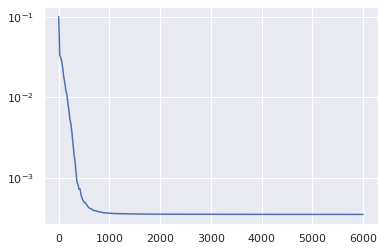

In [37]:
plt.semilogy(df.index, df['MSE_0'])

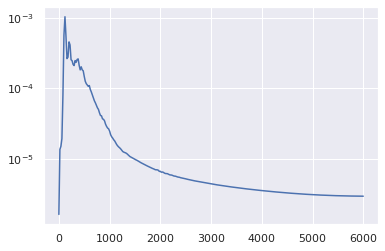

In [38]:
plt.semilogy(df.index, df['Regression_0'])

In [39]:
coeff_keys = [key for key in df.keys() if key[:5] == 'coeff']
scaled_coeff_keys = [key for key in df.keys() if key[:6] == 'scaled']

(-1.5, 1.5)

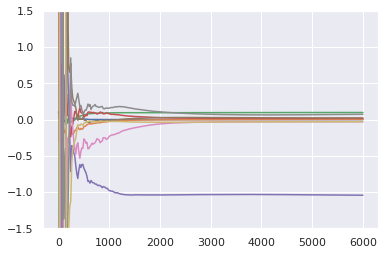

In [40]:
plt.plot(df[coeff_keys])
plt.ylim([-1.5, 1.5])

(-1.5, 1.5)

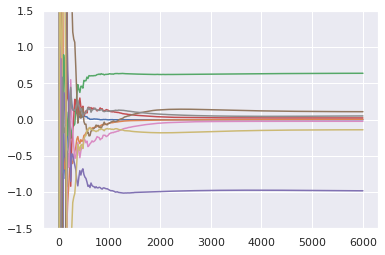

In [41]:
plt.plot(df[scaled_coeff_keys])
plt.ylim([-1.5, 1.5])

(1.5, 3)

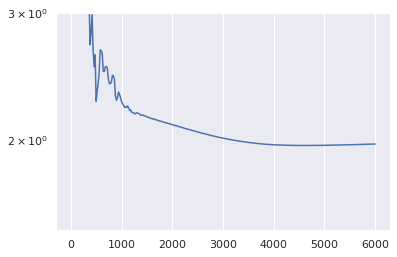

In [48]:
plt.semilogy(df[scaled_coeff_keys].abs().sum(axis=1))
plt.ylim([1.5, 3])

In [53]:
df[scaled_coeff_keys].abs().sum(axis=1).iloc[-1] / df[scaled_coeff_keys].abs().sum(axis=1).argmin()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  """Entry point for launching an IPython kernel.


0.00042931956066952453

Looking good, now let's apply a thresholder:

In [58]:
prediction, time_deriv_list, sparse_theta_list, coeff_vector_list, theta = model(X_train)
model.constraints.sparsity_mask = model.calculate_sparsity_mask(theta, time_deriv_list)

and train another run:

In [59]:
train(model, X_train, y_train, optimizer, 5000, loss_func_args={'library':torch.tensor(theta) ,'time_deriv': torch.tensor(dt)})

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       LL |
          0      0.00%               0s   -1.22e+01   3.49e-04   1.06e-05   1.06e-05 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


       5000    100.00%               0s   -1.22e+01   3.49e-04   3.38e-06   3.38e-06 

In [60]:
model.constraints.coeff_vector[0]

tensor([[-7.2658e-05],
        [ 1.0144e-01],
        [-9.9805e-01],
        [-6.4989e-03]], grad_fn=<MmBackward>)

In [63]:
df = load_tensorboard('runs/Apr28_12-45-46_16939e04ebf6/')
coeff_keys = [key for key in df.keys() if key[:5] == 'coeff']
scaled_coeff_keys = [key for key in df.keys() if key[:6] == 'scaled']

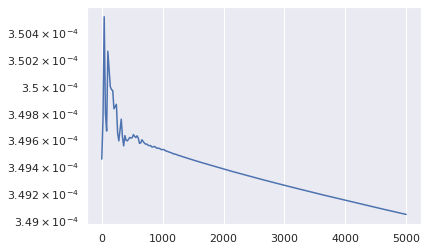

In [69]:
plt.semilogy(df.index, df['MSE_0'])

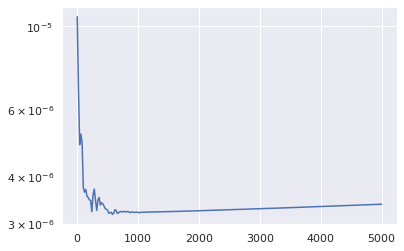

In [70]:
plt.semilogy(df.index, df['Regression_0'])

(-1.5, 1.5)

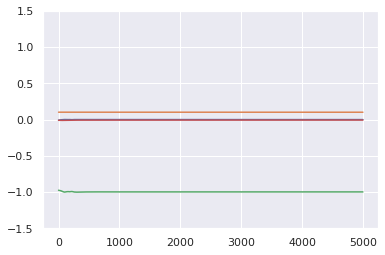

In [71]:
plt.plot(df[coeff_keys])
plt.ylim([-1.5, 1.5])

(-1.5, 1.5)

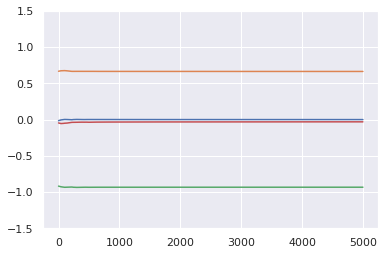

In [72]:
plt.plot(df[scaled_coeff_keys])
plt.ylim([-1.5, 1.5])

(1.5, 2)

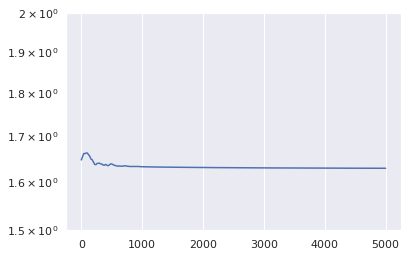

In [73]:
plt.semilogy(df[scaled_coeff_keys].abs().sum(axis=1))
plt.ylim([1.5, 2])

In [74]:
df[scaled_coeff_keys].abs().sum(axis=1).iloc[-1] / df[scaled_coeff_keys].abs().sum(axis=1).argmin()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  """Entry point for launching an IPython kernel.


0.00032565715865057426

In [75]:
prediction, time_deriv_list, sparse_theta_list, coeff_vector_list, theta = model(X_train)

In [77]:
model.constraints.sparsity_mask = model.calculate_sparsity_mask(theta, time_deriv_list)
model.constraints.sparsity_mask

[tensor([False,  True,  True, False,  True, False, False, False, False])]

In [78]:
train(model, X_train, y_train, optimizer, 5000, loss_func_args={'library':torch.tensor(theta) ,'time_deriv': torch.tensor(dt)})

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       LL |
          0      0.00%               0s   -1.22e+01   3.49e-04   1.44e-05   1.44e-05 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


       5000    100.00%               0s   -1.22e+01   3.49e-04   3.92e-06   3.92e-06 

In [81]:
df = load_tensorboard('runs/Apr28_12-52-49_16939e04ebf6/')
coeff_keys = [key for key in df.keys() if key[:5] == 'coeff']
scaled_coeff_keys = [key for key in df.keys() if key[:6] == 'scaled']

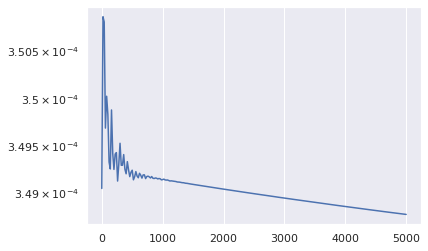

In [82]:
plt.semilogy(df.index, df['MSE_0'])

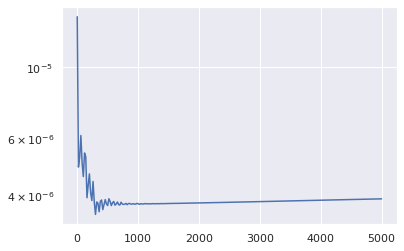

In [83]:
plt.semilogy(df.index, df['Regression_0'])

(-1.5, 1.5)

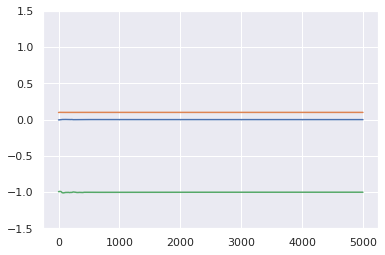

In [84]:
plt.plot(df[coeff_keys])
plt.ylim([-1.5, 1.5])

(-1.5, 1.5)

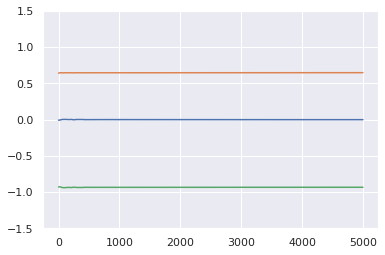

In [85]:
plt.plot(df[scaled_coeff_keys])
plt.ylim([-1.5, 1.5])

(1.5, 2)

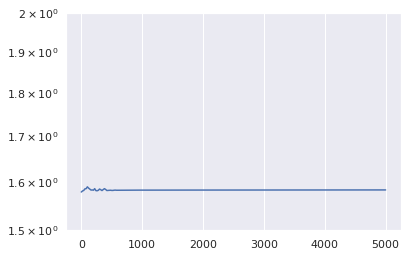

In [86]:
plt.semilogy(df[scaled_coeff_keys].abs().sum(axis=1))
plt.ylim([1.5, 2])

In [89]:
df[scaled_coeff_keys].abs().sum(axis=1).iloc[-1] / df[scaled_coeff_keys].abs().sum(axis=1).min() - 1

0.0027770025701467915

In [90]:
prediction, time_deriv_list, sparse_theta_list, coeff_vector_list, theta = model(X_train)

In [91]:
model.constraints.sparsity_mask = model.calculate_sparsity_mask(theta, time_deriv_list)
model.constraints.sparsity_mask

[tensor([False,  True,  True, False,  True, False, False, False, False])]

In [92]:
df[scaled_coeff_keys].iloc[-1]

scaled_coeff_0_0   -0.001329
scaled_coeff_0_1    0.647167
scaled_coeff_0_2   -0.933801
Name: 5000, dtype: float64

In [93]:
df[coeff_keys].iloc[-1]

coeff_0_0   -0.000726
coeff_0_1    0.099150
coeff_0_2   -1.002038
Name: 5000, dtype: float64

In [151]:
from sklearn.linear_model import LassoLarsCV, LassoCV, ElasticNetCV, LarsCV, OrthogonalMatchingPursuitCV, ARDRegression


In [165]:
final_test = LassoLarsIC(fit_intercept=False)
#final_test = LassoLarsCV(fit_intercept=False,)
#final_test = LassoCV(fit_intercept=False)
#final_test = ElasticNetCV(fit_intercept=False, l1_ratio=np.linspace(0.1, 1, 10))
#final_test = LarsCV(fit_intercept=False)
#final_test = OrthogonalMatchingPursuitCV(fit_intercept=False)
#final_test = ARDRegression(fit_intercept=True)

In [166]:
dt = (time_deriv_list[0] / torch.norm(time_deriv_list[0])).detach().cpu().numpy()
theta_normed = (theta / torch.norm(theta, dim=0, keepdim=True)).detach().cpu().numpy()

In [175]:
final_test.fit(theta_normed, dt).coef_

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([ 0.        , -0.00252872,  0.64488423,  0.        , -0.93067701,
        0.        ,  0.        ,  0.        ,  0.        ])

In [178]:
model.constraints.sparsity_mask[0].cpu().numpy()

array([False,  True,  True, False,  True, False, False, False, False])

In [179]:
final_test.fit(theta_normed[:, model.constraints.sparsity_mask[0].cpu().numpy()], dt).coef_

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([-0.00132858,  0.64716661, -0.93380157])

In [ ]:
time_derivs_normed = [(time_deriv / torch.norm(time_deriv, keepdim=True)).detach().cpu().numpy() for time_deriv in time_derivs] 
theta_normed = (theta / torch.norm(theta, dim=0, keepdim=True)).detach().cpu().numpy()
        

So it seems to work :), let's put it all in one fuinction:

In [183]:
def train(model, data, target, optimizer, max_iterations, loss_func_args):
    '''Trains the deepmod model with MSE, regression and l1 cost function. Updates model in-place.'''
    start_time = time.time()
    number_of_terms = [coeff_vec.shape[0] for coeff_vec in model(data)[3]]
    board = Tensorboard(number_of_terms)
    
    l1_minimum = torch.tensor(100)
    coeffs_converged = False
    # Training
    print('| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       LL |')
    for iteration in torch.arange(0, max_iterations + 1):
        # Calculating prediction and library and scaling
        prediction, time_deriv_list, sparse_theta_list, coeff_vector_list, theta = model(data)
        coeff_vector_scaled_list = scaling(coeff_vector_list, sparse_theta_list, time_deriv_list) 
        
        # Calculating loss
        loss_mse = mse_loss(prediction, target)
        loss_reg = reg_loss(time_deriv_list, sparse_theta_list, coeff_vector_list)
        loss = torch.sum(2 * torch.log(2 * pi * loss_mse) + loss_reg / loss_mse) 
        
        # Writing
        if iteration % 20 == 0:
            # Write progress to command line
            progress(iteration, start_time, max_iterations, loss.item(), torch.sum(loss_mse).item(), torch.sum(loss_reg).item(), torch.sum(loss_reg).item())
            
            # Before writing to tensorboard, we need to fill the missing values with 0
            coeff_vectors_padded = [torch.zeros(mask.size()).masked_scatter_(mask, coeff_vector.squeeze()) for mask, coeff_vector in zip(model.constraints.sparsity_mask, coeff_vector_list)]
            scaled_coeff_vectors_padded = [torch.zeros(mask.size()).masked_scatter_(mask, coeff_vector.squeeze()) for mask, coeff_vector in zip(model.constraints.sparsity_mask, coeff_vector_scaled_list)]
            
            board.write(iteration, loss, loss_mse, loss_reg, loss_reg, coeff_vectors_padded, scaled_coeff_vectors_padded)
            
        # Checking convergence
        if iteration > loss_func_args['initial_conv_check']:
            l1_norm = torch.sum(torch.abs(coeff_vector_scaled_list[0]))
            if l1_norm < l1_minimum:
                l1_minimum = l1_norm
            coeffs_converged = (l1_norm / l1_minimum).item() > 1 + loss_func_args['threshold']
        catch_condition = (iteration >= loss_func_args['start_sparsity_update']) and (iteration % loss_func_args['sparsity_update_period'] == 0)
        
        # Updating sparsity mask
        if coeffs_converged or catch_condition:
            with torch.no_grad():
                model.constraints.sparsity_mask = model.calculate_sparsity_mask(theta, time_deriv_list)
            
        # Optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()    
    board.close()


In [ ]:
threshold
initial_convergence
max_sparsity_update
sparsity_update_period
